In [32]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch import optim
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from tqdm import trange
import random
from sklearn.manifold import TSNE
import os
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
import scipy.stats as sst

In [3]:
X=[0.6,0.95,1.45,2.1,2.56,3.54,3.89,4.37,4.82,5.66,6.11,6.23]
Y=[1860,1750,1710,1690,1678,1640,1620,1576,1566,1498,1425,1419]

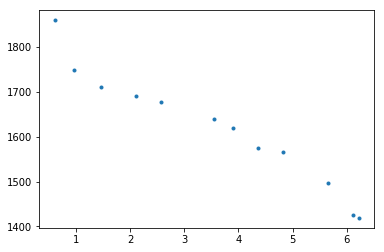

In [5]:
plt.plot(X,Y,'.')
plt.show()

In [14]:
lrModel = LinearRegression()
lrModel.fit(np.array(X).reshape(12,1),Y)
lrModel.score(np.array(X).reshape(12,1),Y)

0.9468287338330007

In [20]:
alpha = lrModel.intercept_
beta = lrModel.coef_[0]
print('alpha',alpha)
print('beta',beta)
#alpha + beta*numpy.array([60,70])

alpha 1845.4749684167004
beta -64.18400238884594


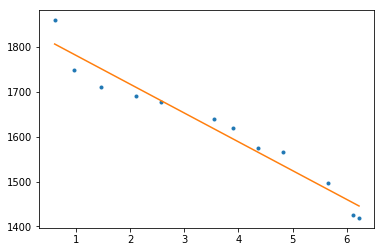

In [22]:
plt.plot(X,Y,'.')
plt.plot(X,lrModel.predict(np.array(X).reshape(12,1)))
plt.show()

In [30]:
#计算置信区间
#对升序序列找到对匹配val值最接近的点坐标
def index_fit(y, val):
    if val >= y[-1]:
        return len(y) - 1
    for i, yi in enumerate(y):
        if val >= yi and val <= y[i + 1]:
            if abs(val - yi) <= abs(val - y[ i + 1]):
                fit_index = i
            else:
                fit_index = i+1
            break
    return fit_index

#用于计算Lxx, Lyy
def laa(x):
    x_mean = np.mean(x)
    lxx = np.sum((x-x_mean)**2)
    return lxx

#用于计算Lxy
def lab(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    lxy = np.sum((x-x_mean)*(y-y_mean))
    return lxy
#一元线性回归模型
def polyfit_one(x, y, alpha):
    assert len(x) == len(y)
    n = len(x)
    assert n > 2
    lxx = laa(x)
    lyy = laa(y)
    lxy = lab(x, y)

    R = lxy/(np.sqrt(lxx) * np.sqrt(lyy))
    R2 = R*R   #计算相关系数与决定系数

    b_est = lxy/lxx  #计算b估计
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    a_est = y_mean - b_est * x_mean   #计算a估计
    Qe = lyy - b_est * lxy
    sigma_est2 = Qe / (n - 2)

    sigma_est = np.sqrt(sigma_est2) #sigma估计

    test = np.abs(b_est * np.sqrt(lxx))/sigma_est
    test_level = sst.t.ppf(1 - alpha/2, df=n - 2)
    linear_test = test > test_level   #线性回归检验

    #a,b的置信区间
    b_int = [b_est - test_level * sigma_est / np.sqrt(lxx), b_est + test_level * sigma_est / np.sqrt(lxx)]
    a_int = [y_mean - b_int[1] * x_mean, y_mean - b_int[0] * x_mean]

    poly_int = (a_int, b_int)

    poly_val = (a_est, b_est)

    #返回回归模型相应参数
    test_val = {'R': R,
                'R2': R2,
                'linear_test': linear_test,
                'poly_int': poly_int,
                }
    process_val = {'lxx': lxx,
                   'lyy': lyy,
                   'lxy': lxy,
                   'sigma_est': sigma_est,
                   'x_mean': x_mean,
                   'y_mean': y_mean,
                   'test_level': test_level,
                   'ndim': n,
                   }
    return (poly_val, test_val, process_val)
#计算相应的预测区间
def confidence_interval(y0=None, *args, **kwargs):
    a_est, b_est = args
    sigma_est = kwargs['sigma_est']
    test_level= kwargs['test_level']
    lxx = kwargs['lxx']
    n = kwargs['ndim']
    x_mean = kwargs['x_mean']

    if isinstance(y0, (int, float, np.ndarray)):
        x0 = (y0 - a_est) / b_est
    elif isinstance(y0, (list, tuple)):
        y0 = np.array(y0)
        x0 = (y0 - a_est) / b_est
    else:
        return None

    conf_down = y0 - test_level * sigma_est * np.sqrt(1 + 1 / n + ((x0 - x_mean) ** 2 / lxx))
    conf_up = y0 + test_level * sigma_est * np.sqrt(1 + 1 / n + ((x0 - x_mean) ** 2 / lxx))

    confidence_interval = (conf_down, conf_up)

    return confidence_interval


In [35]:
alpha=0.05
x_pre=4.5
poly_val, test_val, process_val = polyfit_one(X, Y, alpha)
zone = confidence_interval(lrModel.predict(np.array([x_pre]).reshape(1,1)), *poly_val, **process_val)

In [36]:
print(zone)

(array([1482.30680715]), array([1630.98710819]))


In [37]:
lrModel.predict(np.array([x_pre]).reshape(1,1))

array([1556.64695767])